In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt
import numpy as np
from kernels import HMC_vanilla

%matplotlib inline

import random

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS

In [2]:
def set_seeds(rand_seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)
    torch.cuda.manual_seed_all(rand_seed)

set_seeds(1)

# Notebook with simple experiments

## Task 1

### Receiving of the true $\theta$ and generating of a dataset

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

z_dim = 2 # Latent space dimensionality
data_dim = 10 # Data dimensionality
N = 10000 # Dataset size
N_val = 1000 # Validation Dataset

sigma_0 = 1. # True std

In [4]:
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
std_normal_pyro = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
true_theta = std_normal.sample((z_dim, data_dim)) * sigma_0
print('True decoder matrix')
print(true_theta)
print('-' * 100)

data_probs = torch.sigmoid(std_normal.sample((N, z_dim)) @ true_theta)
data = torch.distributions.Bernoulli(probs=data_probs).sample()

data_probs_val = torch.sigmoid(std_normal.sample((N_val, z_dim)) @ true_theta)
data_val = torch.distributions.Bernoulli(probs=data_probs_val).sample()

print('Generated data example:')
print(data[:10])

True decoder matrix
tensor([[-0.2963,  2.6764, -0.1408, -0.8441,  0.2905, -0.2838, -1.4535,  2.3737,
         -0.0177, -2.7884],
        [-0.3788,  0.7046, -1.3956, -0.1248, -0.9259, -1.5463, -0.4902,  0.0244,
         -1.5992, -0.8469]], device='cuda:0')
----------------------------------------------------------------------------------------------------
Generated data example:
tensor([[1., 0., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 0., 1., 1., 0., 0., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 0., 0., 1., 1.],
        [0., 1., 1., 1., 1., 1., 0., 1., 0., 1.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 0., 0., 1., 0., 0.],
        [1., 0., 0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 1., 1.]], device='cuda:0')


In [5]:
print('!!!!!')
previous_theta = torch.tensor([[-0.296278  ,  2.676448  , -0.1408463 , -0.84409505,  0.29053846,
        -0.28383088, -1.4534557 ,  2.3736813 , -0.01774164, -2.7884495 ],
       [-0.37882465,  0.7045725 , -1.3956138 , -0.12478404, -0.9258568 ,
        -1.5463208 , -0.49016267,  0.02436782, -1.5992415 , -0.8468648 ]], dtype=torch.float32, device=device)
assert(np.abs(previous_theta.cpu().numpy() - true_theta.cpu().numpy()) < 1e-8).all()
print('OK!')

!!!!!
OK!


## Task 2

### Sample z with target $p(z|x)$, using NUTS

#### 1) Bernoulli likelihood from torch

In [6]:
n_warmup = 20000
n_samples = 1000

data_ind = 0  #  index of datapoint we conditioned on

In [5]:
def potential_fn(z):
    z = z['points']
    probs = torch.sigmoid(z @ true_theta)
    return -torch.sum(pyro.distributions.Bernoulli(probs=probs).log_prob(data[data_ind][None]).sum(1) + std_normal_pyro.log_prob(z).sum(1))

In [6]:
init_samples = std_normal_pyro.sample((1, z_dim))
init_params = {'points': init_samples}

nuts_kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(nuts_kernel,
            initial_params=init_params,
            num_samples=n_samples,
            warmup_steps=n_warmup)

mcmc.run()
z = mcmc.get_samples()['points'].squeeze()

Sample: 100%|██████████| 21000/21000 [01:54, 183.57it/s, step size=8.80e-01, acc. prob=0.906]


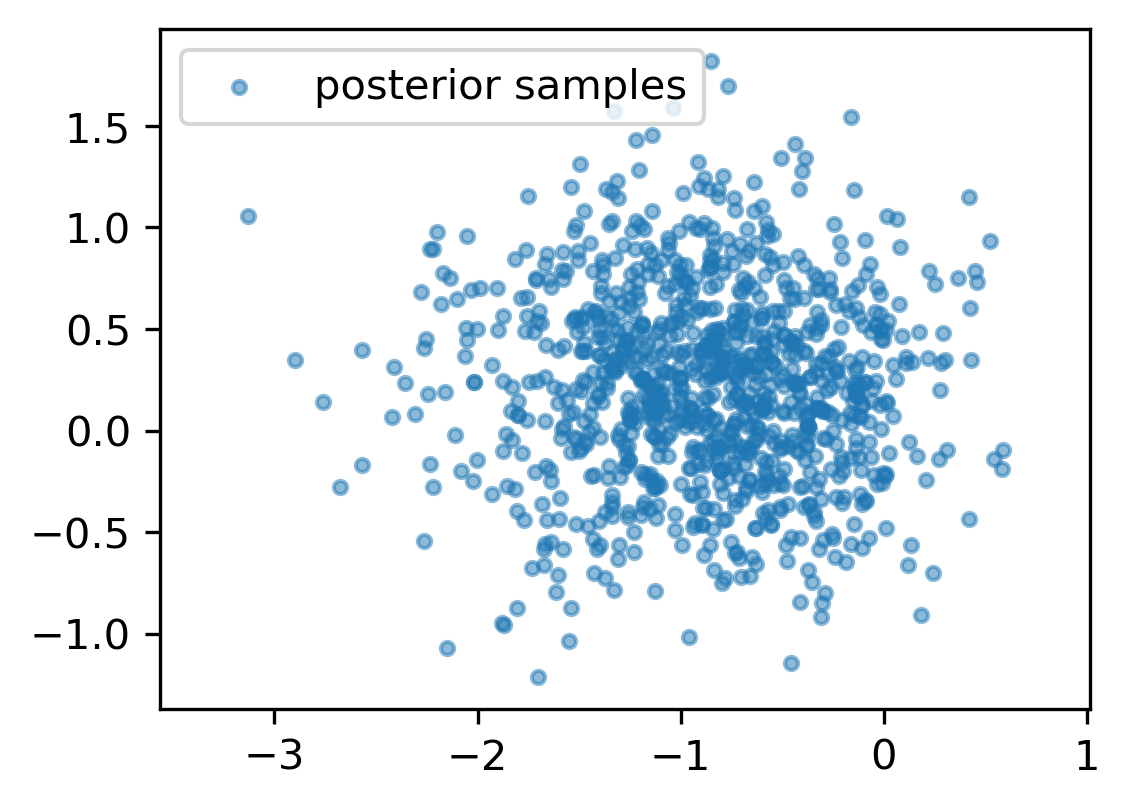

In [7]:
plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), label='posterior samples', s=10, alpha=0.5)
plt.legend()
plt.axis('equal');

### Sample z with target $p(z|x)$, using our HMC

In [6]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict({})

args.device = device

args.N = 5

args.alpha = 0.5
args.use_partialref = False

args.gamma = 0.1
args.use_barker = False

In [7]:
class Target():
    def __init__(self,):
        pass
    def get_logdensity(self, z, x):
        probs = torch.sigmoid(z @ true_theta)
        return torch.distributions.Bernoulli(probs=probs).log_prob(x).sum(1) + std_normal.log_prob(z).sum(1)
target = Target()

In [10]:
transitions = HMC_vanilla(args)
z = std_normal.sample((1, z_dim))
momentum = std_normal.sample(z.shape)

print('Warm up')
for i in tqdm(range(n_warmup)):
    z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=data[data_ind][None])
    
print('Sampling')
samples = []
for i in tqdm(range(n_samples)):
    z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=data[data_ind][None])
    samples.append(z.cpu().detach().numpy())

  0%|          | 16/20000 [00:00<02:06, 157.50it/s]

Warm up


  2%|▏         | 16/1000 [00:00<00:06, 150.57it/s]

Sampling


100%|██████████| 1000/1000 [00:06<00:00, 148.30it/s]


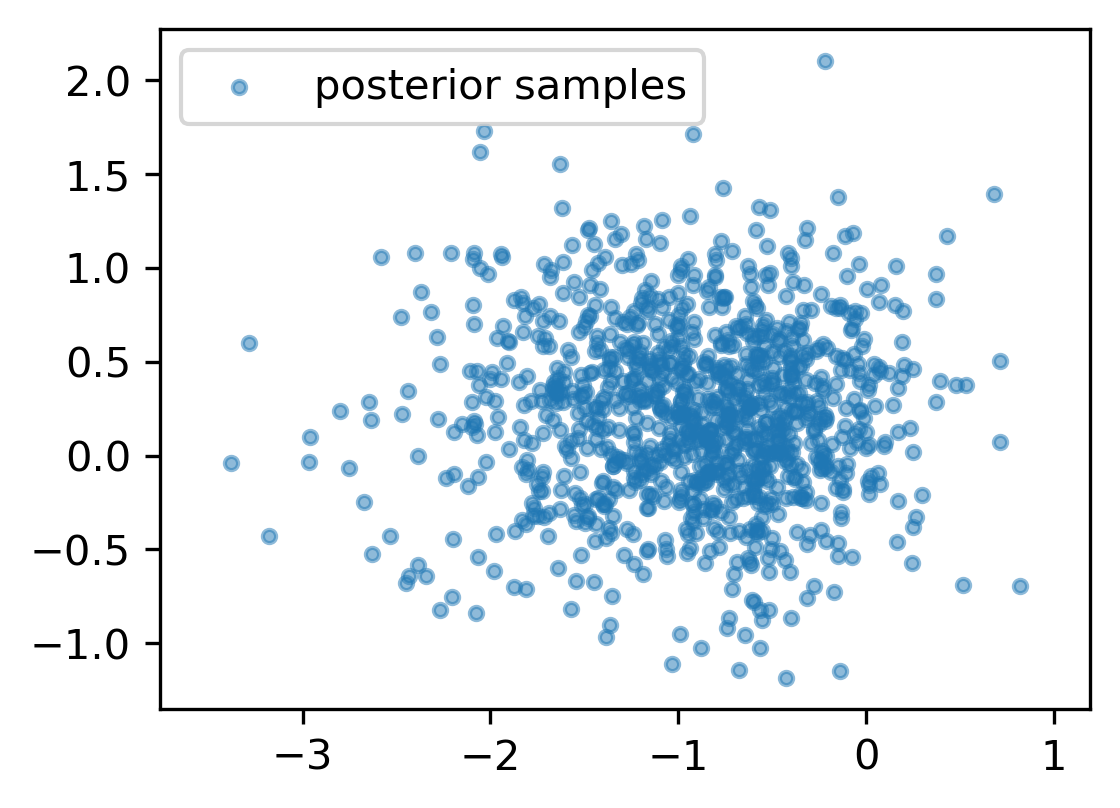

In [11]:
samples = np.array(samples).squeeze()

plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(samples[:, 0], samples[:, 1], label='posterior samples', s=10, alpha=0.5)
plt.legend()
plt.axis('equal');

## Task 3

In [8]:
class Decoder(nn.Module):
    def __init__(self, data_dim, z_dim):
        super(Decoder, self).__init__()
        self.W = nn.Linear(in_features=z_dim, out_features=data_dim, bias=False)
    def forward(self, z):
        return self.W(z)

#### Fisher's identity, NUTS

In [9]:
num_epoches = 10
batch_size = 1
n_samples = 10
n_warmup = 25

print_info_ = 1

In [10]:
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [12]:
dec = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(params=dec.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max')

In [13]:
def potential_fn(z):
    z = z['points']
    probs = torch.sigmoid(z @ current_matrix)
    return -torch.sum(pyro.distributions.Bernoulli(probs=probs).log_prob(batch_train).sum(1) + std_normal_pyro.log_prob(z).sum(1))

In [6]:
# for ep in tqdm(range(num_epoches)): # cycle over epoches
#     plt.close()
#     j = 0
#     obj_sum = 0
#     for b_num, batch_train in enumerate(dataloader): # cycle over batches
        
#         init_samples = std_normal.sample((batch_train.shape[0], z_dim))
#         init_params = {'points': init_samples}
        
#         current_matrix = dec.W.weight.detach().T
        
#         nuts_kernel = NUTS(potential_fn=potential_fn)
#         mcmc = MCMC(nuts_kernel,
#                     initial_params=init_params,
#                     num_samples=n_samples,
#                     warmup_steps=n_warmup,
#                    disable_progbar=True)
#         mcmc.run()
#         z = mcmc.get_samples()['points'][-n_samples:].squeeze(1)
        
# #         pdb.set_trace()
        
#         probs = torch.sigmoid(dec(z))
#         obj = torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean()

#         (-obj).backward()
#         optimizer.step()
#         optimizer.zero_grad()
        
#         j += 1
#         obj_sum += obj.cpu().detach().numpy()
# #     scheduler.step(obj)
#     obj_sum /= j
#     if ep % print_info_ == 0:
#         print('obj mean over epoch:', obj_sum)
#         print('obj:', obj.cpu().detach().item())

In [7]:
# print('true_theta', true_theta)
# print('-' * 100)
# print(dec.W.weight.detach().T)

#### Fisher's identity, our HMC

In [11]:
num_epoches = 100
batch_size = 200

print_info_ = 5

K_wu = 70
K_s = 30
args.N = 2

In [12]:
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [13]:
dec = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(params=dec.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max')

transitions = HMC_vanilla(args)

In [14]:
class Target():
    def __init__(self,):
        pass
    def get_logdensity(self, z, x):
        probs = torch.sigmoid(dec(z))
        return torch.distributions.Bernoulli(probs=probs).log_prob(x).sum(1) + std_normal.log_prob(z).sum(1)
target = Target()

In [16]:
for ep in tqdm(range(num_epoches)): # cycle over epoches
    j = 0
    obj_sum = 0
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
        
        momentum = std_normal.sample((batch_train.shape[0], z_dim))
        z = std_normal.sample((batch_train.shape[0], z_dim))

#         pdb.set_trace()
        for _ in range(K_wu):
            z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=batch_train)
            
        obj = 0
        for _ in range(K_s):
            z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=batch_train)
            probs = torch.sigmoid(dec(z))
            obj += torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean()
            
        obj /= K_s 

        (-obj).backward()
        optimizer.step()
        optimizer.zero_grad()
        
        j += 1
        obj_sum += obj.cpu().detach().numpy()
    scheduler.step(obj)
    obj_sum /= j
    if ep % print_info_ == 0:
        print('obj mean over epoch:', obj_sum)
        print('obj:', obj.cpu().detach().item())
        print(dec.W.weight.detach().T)

  1%|          | 1/100 [00:21<36:13, 21.96s/it]

obj mean over epoch: -0.6818459796905517
obj: -0.6818204522132874
tensor([[ 0.3506, -0.1850, -0.6176, -0.0999,  0.0768,  0.2006,  0.3022, -0.0967,
          0.0817,  0.6282],
        [-0.2804,  0.2914,  0.4016,  0.3288, -0.0665,  0.0546, -0.2405, -0.0538,
          0.0127,  0.1961]], device='cuda:0')


  6%|▌         | 6/100 [02:11<34:19, 21.91s/it]

obj mean over epoch: -0.6554131543636322
obj: -0.6574333310127258
tensor([[ 0.3930, -0.4472, -0.3515,  0.1464,  0.0190,  0.2815,  0.5484, -0.3593,
          0.1785,  0.8689],
        [-0.1488,  0.0875,  0.4066,  0.2218,  0.0423,  0.1738, -0.0678, -0.0478,
          0.1592,  0.1588]], device='cuda:0')


 11%|█         | 11/100 [04:00<32:14, 21.74s/it]

obj mean over epoch: -0.6210520422458649
obj: -0.6148911714553833
tensor([[ 0.4090, -0.7073, -0.1124,  0.3590,  0.0058,  0.3921,  0.7835, -0.6041,
          0.2565,  1.1385],
        [ 0.0119, -0.1080,  0.5421,  0.2226,  0.2036,  0.3548,  0.1047, -0.1452,
          0.3477,  0.2803]], device='cuda:0')


 16%|█▌        | 16/100 [05:50<30:43, 21.95s/it]

obj mean over epoch: -0.5933061122894288
obj: -0.5750805735588074
tensor([[ 0.3821, -0.9236,  0.0454,  0.5155, -0.0410,  0.3794,  0.9652, -0.8134,
          0.2293,  1.3562],
        [ 0.1525, -0.2714,  0.7257,  0.2087,  0.3744,  0.5732,  0.2229, -0.1739,
          0.5574,  0.4065]], device='cuda:0')


 21%|██        | 21/100 [07:40<28:53, 21.95s/it]

obj mean over epoch: -0.5705622327327728
obj: -0.5847100019454956
tensor([[ 0.3358, -1.1092,  0.1181,  0.6284, -0.1127,  0.3300,  1.0989, -0.9952,
          0.1636,  1.5381],
        [ 0.2684, -0.3437,  0.9194,  0.1508,  0.5376,  0.7788,  0.3061, -0.1475,
          0.7704,  0.4906]], device='cuda:0')


 26%|██▌       | 26/100 [09:29<26:41, 21.64s/it]

obj mean over epoch: -0.5554266011714936
obj: -0.5482836961746216
tensor([[ 0.3014, -1.2732,  0.1413,  0.6979, -0.1893,  0.2755,  1.2066, -1.1647,
          0.1005,  1.6953],
        [ 0.3560, -0.3971,  1.0579,  0.1324,  0.6624,  0.9595,  0.3689, -0.1004,
          0.9603,  0.5455]], device='cuda:0')


 31%|███       | 31/100 [11:18<25:08, 21.86s/it]

obj mean over epoch: -0.545514030456543
obj: -0.5528114438056946
tensor([[ 0.2881, -1.4163,  0.1432,  0.7473, -0.2375,  0.2407,  1.2872, -1.3098,
          0.0605,  1.8360],
        [ 0.4018, -0.4167,  1.1713,  0.1360,  0.7627,  1.1116,  0.4047, -0.0848,
          1.1047,  0.5865]], device='cuda:0')


 36%|███▌      | 36/100 [13:08<23:28, 22.00s/it]

obj mean over epoch: -0.5382168388366699
obj: -0.5576265454292297
tensor([[ 0.2839, -1.5477,  0.1365,  0.7816, -0.2648,  0.2312,  1.3428, -1.4341,
          0.0360,  1.9579],
        [ 0.4164, -0.4487,  1.2478,  0.1035,  0.8222,  1.2172,  0.4351, -0.0739,
          1.2182,  0.6136]], device='cuda:0')


 41%|████      | 41/100 [14:58<21:33, 21.93s/it]

obj mean over epoch: -0.5336227011680603
obj: -0.5168001055717468
tensor([[ 0.2755, -1.6684,  0.1307,  0.8065, -0.2793,  0.2198,  1.3748, -1.5484,
          0.0267,  2.0671],
        [ 0.4192, -0.4712,  1.2988,  0.0948,  0.8693,  1.3059,  0.4616, -0.0696,
          1.3067,  0.6572]], device='cuda:0')


 46%|████▌     | 46/100 [16:47<19:40, 21.86s/it]

obj mean over epoch: -0.5284053671360016
obj: -0.540325403213501
tensor([[ 0.2683, -1.7772,  0.1230,  0.8151, -0.2982,  0.2218,  1.3909, -1.6510,
          0.0167,  2.1560],
        [ 0.4298, -0.4991,  1.3497,  0.0975,  0.8920,  1.3797,  0.4770, -0.0476,
          1.3826,  0.6923]], device='cuda:0')


 51%|█████     | 51/100 [18:36<17:51, 21.88s/it]

obj mean over epoch: -0.5269154936075211
obj: -0.516714870929718
tensor([[ 0.2678, -1.8784,  0.1216,  0.8074, -0.3133,  0.2123,  1.3981, -1.7516,
         -0.0065,  2.2440],
        [ 0.4135, -0.5271,  1.3804,  0.1126,  0.9083,  1.4205,  0.4949, -0.0510,
          1.4479,  0.7206]], device='cuda:0')


 56%|█████▌    | 56/100 [20:25<16:02, 21.88s/it]

obj mean over epoch: -0.5256372678279877
obj: -0.5239619016647339
tensor([[ 0.2692, -1.9739,  0.1136,  0.8126, -0.3126,  0.2197,  1.4113, -1.8350,
         -0.0043,  2.3154],
        [ 0.4255, -0.5413,  1.3914,  0.1365,  0.9082,  1.4596,  0.4924, -0.0545,
          1.4883,  0.7606]], device='cuda:0')


 61%|██████    | 61/100 [22:14<14:12, 21.86s/it]

obj mean over epoch: -0.5234789991378784
obj: -0.5167816877365112
tensor([[ 0.2626, -2.0609,  0.1149,  0.8139, -0.3142,  0.2110,  1.4254, -1.9081,
         -0.0036,  2.3772],
        [ 0.4271, -0.5637,  1.3987,  0.1432,  0.9212,  1.4876,  0.4958, -0.0537,
          1.5184,  0.7817]], device='cuda:0')


 66%|██████▌   | 66/100 [24:04<12:25, 21.93s/it]

obj mean over epoch: -0.5228129190206527
obj: -0.5155820250511169
tensor([[ 0.2739, -2.1400,  0.1143,  0.8186, -0.3147,  0.2108,  1.4276, -1.9807,
         -0.0192,  2.4369],
        [ 0.4273, -0.5895,  1.4069,  0.1332,  0.9025,  1.5163,  0.5000, -0.0459,
          1.5456,  0.7960]], device='cuda:0')


 71%|███████   | 71/100 [25:52<10:26, 21.62s/it]

obj mean over epoch: -0.5212200266122818
obj: -0.5024914741516113
tensor([[ 0.2718, -2.2063,  0.1256,  0.8250, -0.3176,  0.2180,  1.4331, -2.0442,
         -0.0202,  2.4947],
        [ 0.4305, -0.5966,  1.4148,  0.1257,  0.9180,  1.5311,  0.5053, -0.0464,
          1.5597,  0.8166]], device='cuda:0')


 76%|███████▌  | 76/100 [27:42<08:45, 21.88s/it]

obj mean over epoch: -0.5211470973491669
obj: -0.5214191675186157
tensor([[ 0.2817, -2.2801,  0.1179,  0.8204, -0.3081,  0.2201,  1.4305, -2.0949,
         -0.0132,  2.5407],
        [ 0.4334, -0.6066,  1.4119,  0.1293,  0.9196,  1.5379,  0.5087, -0.0338,
          1.5772,  0.8264]], device='cuda:0')


 81%|████████  | 81/100 [29:31<06:56, 21.93s/it]

obj mean over epoch: -0.51953433573246
obj: -0.5081154704093933
tensor([[ 0.2781, -2.3397,  0.1195,  0.8231, -0.3134,  0.2260,  1.4373, -2.1452,
         -0.0113,  2.5769],
        [ 0.4223, -0.6113,  1.4072,  0.1291,  0.9201,  1.5348,  0.4985, -0.0257,
          1.5844,  0.8270]], device='cuda:0')


 86%|████████▌ | 86/100 [31:21<05:06, 21.89s/it]

Epoch    86: reducing learning rate of group 0 to 1.0000e-04.
obj mean over epoch: -0.5186015772819519
obj: -0.5116547346115112
tensor([[ 0.2795, -2.3944,  0.1387,  0.8234, -0.3114,  0.2386,  1.4294, -2.1923,
         -0.0146,  2.6065],
        [ 0.4353, -0.6237,  1.4096,  0.1285,  0.9242,  1.5569,  0.4850, -0.0104,
          1.5899,  0.8400]], device='cuda:0')


 91%|█████████ | 91/100 [33:09<03:15, 21.71s/it]

obj mean over epoch: -0.518067267537117
obj: -0.5211254954338074
tensor([[ 0.2794, -2.4001,  0.1374,  0.8245, -0.3109,  0.2381,  1.4293, -2.1973,
         -0.0128,  2.6092],
        [ 0.4347, -0.6228,  1.4104,  0.1284,  0.9226,  1.5569,  0.4873, -0.0112,
          1.5916,  0.8400]], device='cuda:0')


 96%|█████████▌| 96/100 [34:57<01:27, 21.76s/it]

obj mean over epoch: -0.5185764127969742
obj: -0.5265032649040222
tensor([[ 0.2795, -2.4067,  0.1374,  0.8247, -0.3103,  0.2385,  1.4288, -2.2035,
         -0.0123,  2.6126],
        [ 0.4336, -0.6218,  1.4109,  0.1282,  0.9225,  1.5565,  0.4885, -0.0103,
          1.5925,  0.8396]], device='cuda:0')


100%|██████████| 100/100 [36:25<00:00, 21.86s/it]


In [17]:
print('true_theta', true_theta)
print('-' * 100)
print(dec.W.weight.detach().T)

true_theta tensor([[-0.2963,  2.6764, -0.1408, -0.8441,  0.2905, -0.2838, -1.4535,  2.3737,
         -0.0177, -2.7884],
        [-0.3788,  0.7046, -1.3956, -0.1248, -0.9259, -1.5463, -0.4902,  0.0244,
         -1.5992, -0.8469]], device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([[ 0.2803, -2.4114,  0.1371,  0.8240, -0.3101,  0.2390,  1.4298, -2.2064,
         -0.0103,  2.6150],
        [ 0.4324, -0.6232,  1.4090,  0.1279,  0.9218,  1.5551,  0.4884, -0.0096,
          1.5951,  0.8403]], device='cuda:0')


In [20]:
for p in dec.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(dec(u)))
print('true probs', torch.sigmoid(u @ true_theta))

reconstructed probs tensor([[0.4585, 0.9779, 0.6965, 0.2043, 0.7774, 0.6818, 0.1038, 0.9800, 0.7744,
         0.0183],
        [0.4349, 0.6296, 0.3114, 0.4666, 0.3802, 0.2926, 0.4060, 0.5433, 0.2920,
         0.3392],
        [0.5942, 0.0203, 0.4891, 0.7926, 0.3338, 0.5243, 0.9068, 0.0252, 0.4198,
         0.9848],
        [0.5040, 0.2428, 0.4066, 0.6026, 0.3848, 0.4089, 0.6539, 0.2277, 0.3729,
         0.7650],
        [0.4773, 0.7090, 0.4994, 0.4238, 0.5373, 0.4910, 0.3719, 0.6973, 0.5149,
         0.2769],
        [0.5633, 0.0022, 0.2000, 0.8994, 0.1142, 0.2175, 0.9697, 0.0019, 0.1148,
         0.9983],
        [0.7455, 0.0767, 0.9584, 0.6603, 0.8660, 0.9708, 0.8500, 0.2584, 0.9700,
         0.9551],
        [0.5071, 0.5049, 0.5288, 0.4965, 0.5219, 0.5312, 0.4996, 0.5164, 0.5339,
         0.4982],
        [0.7027, 0.0671, 0.9059, 0.6831, 0.7692, 0.9282, 0.8511, 0.1758, 0.9204,
         0.9572],
        [0.5060, 0.8241, 0.6656, 0.3599, 0.6824, 0.6661, 0.2997, 0.8494, 0.7129,
        

## Task 4

### Selecting best annealing coeff

In [4]:
class Encoder_vae(nn.Module):
    def __init__(self, data_dim, z_dim, K):
        super(Encoder_vae, self).__init__()
        self.h1 = nn.Linear(in_features=data_dim, out_features=K)
        self.h2 = nn.Linear(in_features=K, out_features=K)
        self.mu = nn.Linear(in_features=K, out_features=z_dim)
        self.sigma = nn.Linear(in_features=K, out_features=z_dim)
    def forward(self, x):
        h1 = F.selu(self.h1(x))
        h2 = F.selu(self.h2(h1))
        return self.mu(h2), F.softplus(self.sigma(h2))
    
class Decoder(nn.Module):
    def __init__(self, data_dim, z_dim):
        super(Decoder, self).__init__()
        self.W = nn.Linear(in_features=z_dim, out_features=data_dim, bias=False)
    def forward(self, z):
        return self.W(z)

In [5]:
K = 8
num_epoches = 5000
batch_size = 200
print_info_ = 500

dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True)

enc = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params=params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max', patience=150, factor=0.75)

In [6]:
def run_validation(enc, dec):
    for p in enc.parameters():
        p.requires_grad_(False)
        
    for p in dec.parameters():
        p.requires_grad_(False)
        
    j = 0
    elbo_sum = 0
    for b_num, batch_val in enumerate(dataloader_val):
        mu, sigma = enc(batch_val) # sample mu and sigma from encoder
        u = std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + u * sigma # reperametrization trick

        prod = dec(z)
        log_likelihood = torch.mean(torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_val))

        KLD = -0.5 * torch.mean(1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))
        elbo = log_likelihood - KLD
        
        j += 1
        elbo_sum += elbo.cpu().detach().numpy()
        
    elbo_sum /= j
    for p in enc.parameters():
        p.requires_grad_(True)
        
    for p in dec.parameters():
        p.requires_grad_(True)
    return elbo_sum

In [7]:
def run_training(enc, dec, best_beta=None, annealing_beta=True):
    patience = 100
    patience_current = 0
    
    if annealing_beta:
        beta = torch.linspace(0., 1., 20, device=device)
        beta_ind = 0
        beta_current = beta[beta_ind]
        best_ind = 0
    else:
        beta_current = 1.

    best_elbo = -float('inf')

    for ep in tqdm(range(num_epoches)): # cycle over epoches
        plt.close()
        j = 0
        elbo_sum = 0
        for b_num, batch_train in enumerate(dataloader): # cycle over batches
            mu, sigma = enc(batch_train) # sample mu and sigma from encoder
            u = std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
            z = mu + u * sigma # reperametrization trick

            prod = dec(z)
            log_likelihood = torch.mean(torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_train))

            KLD = beta_current * (-0.5) * torch.mean(1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))
            elbo = log_likelihood - KLD
            
            (-elbo).backward()

            optimizer.step()
            optimizer.zero_grad()

            j += 1
            elbo_sum += elbo.cpu().detach().numpy()

        current_val_elbo = run_validation(enc, dec)
        elbo_sum /= j

        if current_val_elbo > best_elbo:
            patience_current = 0
            best_elbo = current_val_elbo
            if annealing_beta:
                best_ind = beta_ind
        else:
            patience_current += 1
            if patience_current >= patience:
                if annealing_beta:
                    beta_ind = min(beta_ind + 1, beta.shape[0] - 1)
                    if best_beta:
                        beta_current = min(beta[beta_ind], best_beta)
                    else:
                        beta_current = beta[beta_ind]
                    patience_current = 0
                    print('Current beta:', beta_current)
                else:
                    break

    #     scheduler.step(elbo_sum)
        if ep % print_info_ == 0:
            print('Current validational ELBO:', current_val_elbo)
            if annealing_beta:
                print('Current best validational ELBO:', best_elbo, 'index:', best_ind)
            else:
                print('Current best validational ELBO:', best_elbo)
            print('elbo mean over epoch:', elbo_sum)
            print('elbo:', elbo.cpu().detach().numpy())
            print('likelihood', log_likelihood.cpu().detach().numpy())
            print('KLD', KLD.cpu().detach().numpy())
    if annealing_beta and (best_beta is None):
        print('Finish')
        print('Best beta', beta[best_ind])
        return beta[best_ind]

In [8]:
best_beta = run_training(enc, dec)

  0%|          | 2/5000 [00:00<12:22,  6.73it/s]

Current validational ELBO: -0.8868447661399841
Current best validational ELBO: -0.8868447661399841 index: 0
elbo mean over epoch: -0.7136506903171539
elbo: -0.70871097
likelihood -0.70871097
KLD 0.0


  2%|▏         | 102/5000 [00:14<11:41,  6.98it/s]

Current beta: tensor(0.0526, device='cuda:0')


  4%|▍         | 202/5000 [00:29<11:25,  7.00it/s]

Current beta: tensor(0.1053, device='cuda:0')


  6%|▌         | 302/5000 [00:43<11:11,  6.99it/s]

Current beta: tensor(0.1579, device='cuda:0')


  8%|▊         | 402/5000 [00:57<10:57,  7.00it/s]

Current beta: tensor(0.2105, device='cuda:0')


 10%|█         | 502/5000 [01:12<10:59,  6.82it/s]

Current beta: tensor(0.2632, device='cuda:0')
Current validational ELBO: -1.0016464591026306
Current best validational ELBO: -0.8868447661399841 index: 0
elbo mean over epoch: -0.6725774908065796
elbo: -0.67419064
likelihood -0.5900403
KLD 0.08415034


 20%|██        | 1002/5000 [02:24<09:34,  6.96it/s]

Current validational ELBO: -0.8152438282966614
Current best validational ELBO: -0.8026437878608703 index: 5
elbo mean over epoch: -0.6809774875640869
elbo: -0.6882651
likelihood -0.64468616
KLD 0.043578904


 24%|██▎       | 1182/5000 [02:50<09:18,  6.83it/s]

Current beta: tensor(0.3158, device='cuda:0')


 30%|███       | 1502/5000 [03:36<08:19,  7.01it/s]

Current validational ELBO: -0.7603131651878356
Current best validational ELBO: -0.7517732739448547 index: 6
elbo mean over epoch: -0.6880233585834503
elbo: -0.6864836
likelihood -0.6522205
KLD 0.034263127


 31%|███       | 1533/5000 [03:40<08:23,  6.88it/s]

Current beta: tensor(0.3684, device='cuda:0')


 38%|███▊      | 1906/5000 [04:34<07:31,  6.85it/s]

Current beta: tensor(0.4211, device='cuda:0')


 40%|████      | 2002/5000 [04:48<07:15,  6.88it/s]

Current validational ELBO: -0.7038480758666992
Current best validational ELBO: -0.7018174171447754 index: 8
elbo mean over epoch: -0.6927162408828735
elbo: -0.6921056
likelihood -0.68340427
KLD 0.008701335


 47%|████▋     | 2367/5000 [05:41<06:16,  6.99it/s]

Current beta: tensor(0.4737, device='cuda:0')


 50%|█████     | 2502/5000 [06:00<06:01,  6.92it/s]

Current validational ELBO: -0.6932408571243286
Current best validational ELBO: -0.6923294782638549 index: 9
elbo mean over epoch: -0.6931653487682342
elbo: -0.6942007
likelihood -0.69406044
KLD 0.00014024122


 51%|█████     | 2544/5000 [06:06<05:51,  6.98it/s]

Current beta: tensor(0.5263, device='cuda:0')


 53%|█████▎    | 2644/5000 [06:21<05:42,  6.88it/s]

Current beta: tensor(0.5789, device='cuda:0')


 55%|█████▍    | 2744/5000 [06:35<05:21,  7.02it/s]

Current beta: tensor(0.6316, device='cuda:0')


 57%|█████▋    | 2844/5000 [06:49<05:07,  7.02it/s]

Current beta: tensor(0.6842, device='cuda:0')


 59%|█████▉    | 2944/5000 [07:04<04:57,  6.92it/s]

Current beta: tensor(0.7368, device='cuda:0')


 60%|██████    | 3002/5000 [07:12<04:48,  6.92it/s]

Current validational ELBO: -0.6931104183197021
Current best validational ELBO: -0.6923294782638549 index: 9
elbo mean over epoch: -0.6931497955322266
elbo: -0.6932607
likelihood -0.693257
KLD 3.7751306e-06


 61%|██████    | 3044/5000 [07:18<04:42,  6.92it/s]

Current beta: tensor(0.7895, device='cuda:0')


 63%|██████▎   | 3144/5000 [07:33<04:29,  6.88it/s]

Current beta: tensor(0.8421, device='cuda:0')


 65%|██████▍   | 3244/5000 [07:47<04:15,  6.87it/s]

Current beta: tensor(0.8947, device='cuda:0')


 67%|██████▋   | 3344/5000 [08:02<04:01,  6.87it/s]

Current beta: tensor(0.9474, device='cuda:0')


 69%|██████▉   | 3444/5000 [08:16<03:44,  6.93it/s]

Current beta: tensor(1., device='cuda:0')


 70%|███████   | 3502/5000 [08:24<03:36,  6.93it/s]

Current validational ELBO: -0.6932005047798157
Current best validational ELBO: -0.6923294782638549 index: 9
elbo mean over epoch: -0.6931353402137757
elbo: -0.6930528
likelihood -0.6930502
KLD 2.6267767e-06


 71%|███████   | 3544/5000 [08:31<03:32,  6.84it/s]

Current beta: tensor(1., device='cuda:0')


 73%|███████▎  | 3644/5000 [08:45<03:15,  6.93it/s]

Current beta: tensor(1., device='cuda:0')


 75%|███████▍  | 3744/5000 [08:59<02:58,  7.02it/s]

Current beta: tensor(1., device='cuda:0')


 77%|███████▋  | 3844/5000 [09:14<02:44,  7.01it/s]

Current beta: tensor(1., device='cuda:0')


 79%|███████▉  | 3944/5000 [09:28<02:30,  7.02it/s]

Current beta: tensor(1., device='cuda:0')


 80%|████████  | 4002/5000 [09:36<02:22,  7.00it/s]

Current validational ELBO: -0.6931321501731873
Current best validational ELBO: -0.6923294782638549 index: 9
elbo mean over epoch: -0.6931594944000244
elbo: -0.6932262
likelihood -0.69322455
KLD 1.6442687e-06


 81%|████████  | 4044/5000 [09:42<02:18,  6.89it/s]

Current beta: tensor(1., device='cuda:0')


 83%|████████▎ | 4144/5000 [09:57<02:02,  7.01it/s]

Current beta: tensor(1., device='cuda:0')


 85%|████████▍ | 4244/5000 [10:11<01:49,  6.92it/s]

Current beta: tensor(1., device='cuda:0')


 87%|████████▋ | 4344/5000 [10:25<01:35,  6.90it/s]

Current beta: tensor(1., device='cuda:0')


 89%|████████▉ | 4444/5000 [10:40<01:20,  6.93it/s]

Current beta: tensor(1., device='cuda:0')


 90%|█████████ | 4502/5000 [10:48<01:11,  6.93it/s]

Current validational ELBO: -0.6932216286659241
Current best validational ELBO: -0.6923294782638549 index: 9
elbo mean over epoch: -0.6931479394435882
elbo: -0.69316006
likelihood -0.6931575
KLD 2.570972e-06


 91%|█████████ | 4544/5000 [10:54<01:05,  6.95it/s]

Current beta: tensor(1., device='cuda:0')


 93%|█████████▎| 4644/5000 [11:09<00:51,  6.90it/s]

Current beta: tensor(1., device='cuda:0')


 95%|█████████▍| 4744/5000 [11:23<00:36,  6.94it/s]

Current beta: tensor(1., device='cuda:0')


 97%|█████████▋| 4844/5000 [11:38<00:22,  6.84it/s]

Current beta: tensor(1., device='cuda:0')


 99%|█████████▉| 4944/5000 [11:52<00:08,  6.96it/s]

Current beta: tensor(1., device='cuda:0')


100%|██████████| 5000/5000 [12:00<00:00,  6.93it/s]

Finish
Best beta tensor(0.4737, device='cuda:0')


In [9]:
print('true_theta', true_theta)
print('-' * 100)
print(dec.W.weight.detach().T)

true_theta tensor([[-0.9821, -0.1576,  0.3191,  0.0583,  0.6680, -0.4230,  1.0121, -0.2582,
          0.5480,  0.2879],
        [ 0.0325, -0.4296,  1.7938,  0.6023,  1.5862,  0.3498,  0.8593,  1.5211,
          0.7112, -0.7169]], device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([[ 0.0026, -0.0026,  0.0072, -0.0031,  0.0083,  0.0016, -0.0003, -0.0034,
          0.0045, -0.0064],
        [-0.0062, -0.0025, -0.0003,  0.0028, -0.0014,  0.0026, -0.0002,  0.0017,
          0.0014,  0.0101]], device='cuda:0')


In [10]:
for p in dec.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(dec(u)))
print('true probs', torch.sigmoid(u @ true_theta))

reconstructed probs tensor([[0.5044, 0.5010, 0.5017, 0.4976, 0.5026, 0.4987, 0.5001, 0.4982, 0.5001,
         0.4923],
        [0.4976, 0.4983, 0.5011, 0.5007, 0.5009, 0.5015, 0.4999, 0.5002, 0.5015,
         0.5036],
        [0.4996, 0.5006, 0.4985, 0.5006, 0.4982, 0.4996, 0.5001, 0.5007, 0.4990,
         0.5011],
        [0.4984, 0.4975, 0.5034, 0.4998, 0.5034, 0.5020, 0.4998, 0.4991, 0.5028,
         0.5016],
        [0.4982, 0.5013, 0.4960, 0.5019, 0.4953, 0.4992, 0.5001, 0.5020, 0.4976,
         0.5042],
        [0.5009, 0.5024, 0.4962, 0.5006, 0.4960, 0.4981, 0.5002, 0.5012, 0.4970,
         0.4996],
        [0.5016, 0.4998, 0.5017, 0.4989, 0.5021, 0.5000, 0.5000, 0.4990, 0.5008,
         0.4969],
        [0.5010, 0.5022, 0.4967, 0.5004, 0.4966, 0.4983, 0.5002, 0.5010, 0.4974,
         0.4993],
        [0.4989, 0.5002, 0.4988, 0.5008, 0.4985, 0.5000, 0.5000, 0.5007, 0.4994,
         0.5021],
        [0.5043, 0.5021, 0.4996, 0.4982, 0.5003, 0.4980, 0.5002, 0.4991, 0.4986,
        

### Best annealing coeff

In [11]:
enc = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params=params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max', patience=150, factor=0.75)

In [12]:
run_training(enc, dec, best_beta)

  0%|          | 1/5000 [00:00<12:02,  6.92it/s]

Current validational ELBO: -0.9425471186637878
Current best validational ELBO: -0.9425471186637878 index: 0
elbo mean over epoch: -0.7202080309391021
elbo: -0.715982
likelihood -0.715982
KLD 0.0


  2%|▏         | 102/5000 [00:14<11:46,  6.94it/s]

Current beta: tensor(0.0526, device='cuda:0')


  4%|▍         | 202/5000 [00:29<11:27,  6.98it/s]

Current beta: tensor(0.1053, device='cuda:0')


  6%|▌         | 302/5000 [00:43<11:17,  6.94it/s]

Current beta: tensor(0.1579, device='cuda:0')


  8%|▊         | 402/5000 [00:57<11:09,  6.86it/s]

Current beta: tensor(0.2105, device='cuda:0')


 10%|█         | 502/5000 [01:12<10:48,  6.94it/s]

Current validational ELBO: -0.936460018157959
Current best validational ELBO: -0.9277833938598633 index: 4
elbo mean over epoch: -0.6676219749450684
elbo: -0.65611494
likelihood -0.584751
KLD 0.071363956


 15%|█▍        | 739/5000 [01:46<10:09,  7.00it/s]

Current beta: tensor(0.2632, device='cuda:0')


 20%|██        | 1002/5000 [02:24<09:36,  6.93it/s]

Current validational ELBO: -0.8142765402793884
Current best validational ELBO: -0.8013211369514466 index: 5
elbo mean over epoch: -0.6801098906993865
elbo: -0.6748081
likelihood -0.6291681
KLD 0.045639988


 23%|██▎       | 1138/5000 [02:44<09:19,  6.91it/s]

Current beta: tensor(0.3158, device='cuda:0')


 28%|██▊       | 1403/5000 [03:22<08:45,  6.84it/s]

Current beta: tensor(0.3684, device='cuda:0')


 30%|███       | 1502/5000 [03:36<08:18,  7.01it/s]

Current validational ELBO: -0.7292935132980347
Current best validational ELBO: -0.7240694999694824 index: 7
elbo mean over epoch: -0.6919648206233978
elbo: -0.6829843
likelihood -0.6609408
KLD 0.022043495


 35%|███▌      | 1753/5000 [04:13<07:50,  6.89it/s]

Current beta: tensor(0.4211, device='cuda:0')


 40%|████      | 2002/5000 [04:48<07:01,  7.11it/s]

Current validational ELBO: -0.6980557680130005
Current best validational ELBO: -0.696004331111908 index: 8
elbo mean over epoch: -0.6928466868400573
elbo: -0.6908715
likelihood -0.68666506
KLD 0.004206393


 44%|████▎     | 2186/5000 [05:14<06:35,  7.11it/s]

Current beta: tensor(0.4737, device='cuda:0')


 48%|████▊     | 2375/5000 [05:40<06:09,  7.10it/s]

Current beta: tensor(0.4737, device='cuda:0')


 50%|████▉     | 2475/5000 [05:55<06:03,  6.94it/s]

Current beta: tensor(0.4737, device='cuda:0')


 50%|█████     | 2502/5000 [05:58<06:00,  6.93it/s]

Current validational ELBO: -0.6931933999061585
Current best validational ELBO: -0.6925230026245117 index: 9
elbo mean over epoch: -0.6931624960899353
elbo: -0.693137
likelihood -0.6931359
KLD 1.098294e-06


 52%|█████▏    | 2575/5000 [06:09<05:45,  7.01it/s]

Current beta: tensor(0.4737, device='cuda:0')


 54%|█████▎    | 2675/5000 [06:23<05:32,  6.99it/s]

Current beta: tensor(0.4737, device='cuda:0')


 56%|█████▌    | 2775/5000 [06:38<05:24,  6.86it/s]

Current beta: tensor(0.4737, device='cuda:0')


 57%|█████▊    | 2875/5000 [06:52<05:08,  6.88it/s]

Current beta: tensor(0.4737, device='cuda:0')


 60%|█████▉    | 2975/5000 [07:07<04:56,  6.82it/s]

Current beta: tensor(0.4737, device='cuda:0')


 60%|██████    | 3002/5000 [07:11<04:52,  6.83it/s]

Current validational ELBO: -0.6931351780891418
Current best validational ELBO: -0.6925230026245117 index: 9
elbo mean over epoch: -0.6931402719020844
elbo: -0.69310015
likelihood -0.69309384
KLD 6.3002617e-06


 62%|██████▏   | 3075/5000 [07:21<04:40,  6.86it/s]

Current beta: tensor(0.4737, device='cuda:0')


 64%|██████▎   | 3175/5000 [07:36<04:24,  6.91it/s]

Current beta: tensor(0.4737, device='cuda:0')


 66%|██████▌   | 3275/5000 [07:50<04:10,  6.89it/s]

Current beta: tensor(0.4737, device='cuda:0')


 68%|██████▊   | 3375/5000 [08:05<03:58,  6.81it/s]

Current beta: tensor(0.4737, device='cuda:0')


 70%|██████▉   | 3475/5000 [08:19<03:42,  6.85it/s]

Current beta: tensor(0.4737, device='cuda:0')


 70%|███████   | 3502/5000 [08:23<03:39,  6.83it/s]

Current validational ELBO: -0.6933105707168579
Current best validational ELBO: -0.6925230026245117 index: 9
elbo mean over epoch: -0.6931028318405151
elbo: -0.69319993
likelihood -0.69317776
KLD 2.2163164e-05


 72%|███████▏  | 3575/5000 [08:34<03:27,  6.87it/s]

Current beta: tensor(0.4737, device='cuda:0')


 74%|███████▎  | 3675/5000 [08:48<03:11,  6.94it/s]

Current beta: tensor(0.4737, device='cuda:0')


 76%|███████▌  | 3775/5000 [09:03<02:56,  6.94it/s]

Current beta: tensor(0.4737, device='cuda:0')


 78%|███████▊  | 3875/5000 [09:17<02:38,  7.11it/s]

Current beta: tensor(0.4737, device='cuda:0')


 80%|███████▉  | 3975/5000 [09:31<02:24,  7.11it/s]

Current beta: tensor(0.4737, device='cuda:0')


 80%|████████  | 4002/5000 [09:35<02:20,  7.11it/s]

Current validational ELBO: -0.6932457208633422
Current best validational ELBO: -0.6925230026245117 index: 9
elbo mean over epoch: -0.6931477427482605
elbo: -0.6931884
likelihood -0.6931758
KLD 1.2645169e-05


 82%|████████▏ | 4075/5000 [09:45<02:10,  7.11it/s]

Current beta: tensor(0.4737, device='cuda:0')


 84%|████████▎ | 4175/5000 [09:59<01:56,  7.10it/s]

Current beta: tensor(0.4737, device='cuda:0')


 86%|████████▌ | 4275/5000 [10:13<01:42,  7.10it/s]

Current beta: tensor(0.4737, device='cuda:0')


 88%|████████▊ | 4375/5000 [10:27<01:27,  7.10it/s]

Current beta: tensor(0.4737, device='cuda:0')


 90%|████████▉ | 4475/5000 [10:41<01:15,  6.91it/s]

Current beta: tensor(0.4737, device='cuda:0')


 90%|█████████ | 4502/5000 [10:45<01:12,  6.83it/s]

Current validational ELBO: -0.6931107640266418
Current best validational ELBO: -0.6925230026245117 index: 9
elbo mean over epoch: -0.693140811920166
elbo: -0.69293785
likelihood -0.6929293
KLD 8.522261e-06


 92%|█████████▏| 4575/5000 [10:56<01:01,  6.92it/s]

Current beta: tensor(0.4737, device='cuda:0')


 94%|█████████▎| 4675/5000 [11:10<00:46,  6.93it/s]

Current beta: tensor(0.4737, device='cuda:0')


 96%|█████████▌| 4775/5000 [11:25<00:32,  6.92it/s]

Current beta: tensor(0.4737, device='cuda:0')


 98%|█████████▊| 4875/5000 [11:39<00:18,  6.88it/s]

Current beta: tensor(0.4737, device='cuda:0')


100%|█████████▉| 4975/5000 [11:53<00:03,  6.95it/s]

Current beta: tensor(0.4737, device='cuda:0')


100%|██████████| 5000/5000 [11:57<00:00,  6.97it/s]


In [13]:
print('true_theta', true_theta)
print('-' * 100)
print(dec.W.weight.detach().T)

true_theta tensor([[-0.9821, -0.1576,  0.3191,  0.0583,  0.6680, -0.4230,  1.0121, -0.2582,
          0.5480,  0.2879],
        [ 0.0325, -0.4296,  1.7938,  0.6023,  1.5862,  0.3498,  0.8593,  1.5211,
          0.7112, -0.7169]], device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([[-0.0038, -0.0014,  0.0045, -0.0040,  0.0028, -0.0013, -0.0005,  0.0025,
         -0.0056, -0.0013],
        [ 0.0055,  0.0022,  0.0039, -0.0004,  0.0009,  0.0094, -0.0050,  0.0012,
          0.0041, -0.0015]], device='cuda:0')


In [14]:
for p in dec.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(dec(u)))
print('true probs', torch.sigmoid(u @ true_theta))

reconstructed probs tensor([[0.5019, 0.5007, 0.4959, 0.5032, 0.4977, 0.4993, 0.5013, 0.4979, 0.5036,
         0.5013],
        [0.5008, 0.5003, 0.4992, 0.5007, 0.4995, 0.5004, 0.5000, 0.4996, 0.5011,
         0.5002],
        [0.4998, 0.4999, 0.5011, 0.4993, 0.5006, 0.5006, 0.4995, 0.5005, 0.4994,
         0.4996],
        [0.4998, 0.4999, 0.4998, 0.5001, 0.4999, 0.4996, 0.5002, 0.4999, 0.4999,
         0.5001],
        [0.5010, 0.5004, 0.5004, 0.5001, 0.5000, 0.5014, 0.4993, 0.5001, 0.5008,
         0.4998],
        [0.4991, 0.4996, 0.5005, 0.4994, 0.5004, 0.4992, 0.5002, 0.5003, 0.4989,
         0.4999],
        [0.4994, 0.4998, 0.5010, 0.4992, 0.5006, 0.5000, 0.4998, 0.5005, 0.4990,
         0.4997],
        [0.5029, 0.5011, 0.4989, 0.5017, 0.4989, 0.5026, 0.4992, 0.4992, 0.5034,
         0.5002],
        [0.5037, 0.5015, 0.5019, 0.5002, 0.5003, 0.5058, 0.4970, 0.5005, 0.5031,
         0.4992],
        [0.4985, 0.4994, 0.4969, 0.5013, 0.4988, 0.4960, 0.5025, 0.4987, 0.4997,
        

### Vanilla VAE

In [15]:
enc = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params=params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max', patience=150, factor=0.75)

In [16]:
run_training(enc, dec, annealing_beta=False)

  0%|          | 1/5000 [00:00<12:00,  6.93it/s]

Current validational ELBO: -0.9495400547981262
Current best validational ELBO: -0.9495400547981262
elbo mean over epoch: -1.001399703025818
elbo: -0.9475206
likelihood -0.7024444
KLD 0.24507625


  4%|▍         | 193/5000 [00:27<11:30,  6.96it/s]

In [17]:
print('true_theta', true_theta)
print('-' * 100)
print(dec.W.weight.detach().T)

true_theta tensor([[-0.9821, -0.1576,  0.3191,  0.0583,  0.6680, -0.4230,  1.0121, -0.2582,
          0.5480,  0.2879],
        [ 0.0325, -0.4296,  1.7938,  0.6023,  1.5862,  0.3498,  0.8593,  1.5211,
          0.7112, -0.7169]], device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([[-0.0042,  0.0084, -0.0006, -0.0001,  0.0011, -0.0055,  0.0033,  0.0027,
          0.0051,  0.0063],
        [ 0.0011, -0.0067,  0.0094, -0.0072,  0.0063,  0.0033,  0.0079,  0.0109,
         -0.0007, -0.0070]], device='cuda:0')


In [18]:
for p in dec.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(dec(u)))
print('true probs', torch.sigmoid(u @ true_theta))

reconstructed probs tensor([[0.5002, 0.4984, 0.5023, 0.4983, 0.5015, 0.5008, 0.5019, 0.5026, 0.4999,
         0.4983],
        [0.5004, 0.4995, 0.4993, 0.5006, 0.4994, 0.5004, 0.4989, 0.4988, 0.4994,
         0.4998],
        [0.4997, 0.5027, 0.4959, 0.5031, 0.4972, 0.4987, 0.4964, 0.4951, 0.5001,
         0.5029],
        [0.4996, 0.5006, 0.5003, 0.4997, 0.5003, 0.4996, 0.5006, 0.5006, 0.5005,
         0.5004],
        [0.5020, 0.4956, 0.5014, 0.4992, 0.5003, 0.5028, 0.4995, 0.5002, 0.4977,
         0.4964],
        [0.4988, 0.5035, 0.4976, 0.5017, 0.4987, 0.4979, 0.4988, 0.4980, 0.5013,
         0.5031],
        [0.5015, 0.4949, 0.5044, 0.4968, 0.5026, 0.5029, 0.5028, 0.5043, 0.4984,
         0.4952],
        [0.4997, 0.5034, 0.4945, 0.5042, 0.4962, 0.4984, 0.4951, 0.4934, 0.5000,
         0.5037],
        [0.4991, 0.5028, 0.4980, 0.5014, 0.4989, 0.4984, 0.4990, 0.4983, 0.5010,
         0.5025],
        [0.5002, 0.5007, 0.4978, 0.5017, 0.4984, 0.4998, 0.4977, 0.4971, 0.4996,
        

### Hoffamn's VAE

In [ ]:
enc_hoff = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K)
dec_hoff = Decoder(data_dim=data_dim, z_dim=z_dim)


In [ ]:


optimizer_phi = torch.optim.Adam(params=enc_hoff.parameters())
optimizer_theta = torch.optim.Adam(params=dec_hoff.parameters())

steps=10
hoffman_other = False
transitions = HMC_vanilla(args)

In [ ]:


print_info = 50

for ep in tqdm(range(num_epoches)):
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
#         pdb.set_trace()
        mu, sigma = enc_hoff(batch_train)
        u = std_normal.sample(mu.shape)
        z = mu + sigma * u # reparametrization trick
        z_hmc = z.detach()
        ###### objective for phi
        ####
        prod = dec_hoff(z)
        exp_log = (batch_train * dec_hoff(mu) - torch.log(1+ torch.exp(prod))).sum(1)
        KLD = (-0.5 * (1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))).sum(1)
        obj_1 = (exp_log - KLD).mean()
        (-obj_1).backward()
        optimizer_phi.step()
        optimizer_phi.zero_grad()
        optimizer_theta.zero_grad()
        ###### objective for theta
        ####
        p_hmc = std_normal.sample(mu.shape)
        obj_2 = 0
        for k in range(steps):
            z_hmc, p_hmc, _, _, _, _ = transitions.make_transition(q_old=z_hmc, p_old=p_hmc, target_distr=target, x=batch_train)
            if hoffman_other:
                probs = torch.sigmoid(dec(z_hmc))
                obj_2 += torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean()
        if hoffman_other:
            obj_2 = obj_2/steps
        else: 
            probs = torch.sigmoid(dec_hoff(z_hmc))
            obj_2 = torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean()
        (-obj_2).backward()
        optimizer_theta.step()
        optimizer_theta.zero_grad()
        
    if ep%print_info ==0:
        print('log-likelihood: ', obj_2.cpu().detach().numpy())
        print('elbo classical: ', obj_1.cpu().detach().numpy())
        print('KL divergence: ', KLD.mean().cpu().detach().numpy())